# A guide for using the Hilbert-Huang Transform in Machine Learning

## Abstract

The `Hilbert–Huang transform` (`HHT`) is a time series analysis technique specifically designed to handle nonlinear and non-stationary time series data. In contrast to other traditional spectral analysis methods, `HHT` is data-adaptive which leads to more physically meaningful components. This data driven decomposition comes at the expense of computational complexity, it is this computation factor which has seen wavelets dominate signal processing pipelines for filtering/de-noising applications. Contrast to conventional spectral analysis methods such as fourier transform and the wavelet transform, the `HHT` does not lose temporal information after transformation. This is a key advantage over alternative time series representation as input into a machine learning models. This paper attempts to showcase a comparative study of `Hilbert–Huang transform`, `Fourier transform` and `wavelet transform` as input representations into machine learning models. In performing the analyses, it is empirically demonstrated that the `Hilbert spectrum` containing estimations for **energy**, **time** and **frequency**, have a learning advantage over alternative representations when dealing with signals which contain nonlinear and/or nonstationary phenomena.   

## Contents

The contents of this Jupyter Notebook are as follows:

1. Introduction 
2. Background
    1. Fourier Transform
    2. Wavelet Transform
    3. Short-Time Fourier Transform (STFT)
3. Hilbert Spectral Analysis
    1. Hilbert Transform
    2. Empirical mode decomposition (EMD)
    3. Empirical mode Reconstruction
    4. Hilbert–Huang transform
4. Practical Machine Learning Applications
    1. UCI-HAR dataset
    2. ECG Dataset
    3. Comparative Analysis 
5. Discussion
6. Conclusions


## Introduction

The following chapter will present background knowledge on Fourier Transform, Wavelet Transform and Short-Time Fourier Transform (STFT), however the 


In this artical we will focus on implementation and theory of the `Hilbert–Huang transform`, related topics  



<div class="alert alert-block alert-warning">
<b>Warning:</b> This guide has been developed and tested using the conda environment <b>`hht`</b>, it is strongly advised to install this enviroment prior to execution of Jupyter Notebook.  
</div>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl

from scipy.signal import hilbert, spectrogram
from PyEMD import EMD
from sklearn.preprocessing import MinMaxScaler

import pywt

from src.HHT import *
from src.biosignal_filter import denoise_biowave

### Custom Functions

In [2]:
def color_map():
    '''Here we define a color map where 0 == white'''
    cmap = plt.cm.cividis

    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))

    # Set alpha
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

    # Create new colormap
    my_cmap = ListedColormap(my_cmap)
    
    return my_cmap

def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    im = ax.contourf(time, np.log2(period), 
                     np.log2(power), 
                     contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
def plot_HHT(ax, fs, signal, cmap = plt.cm.seismic, title = ''):


    T, F, spec_2d, spec_1d = Hilbert_spectrum(signal, fs, freq_div = 2, 
                                    n_components = 4, 
                                    frequency_resolution = .2)

    ax.set_title(title)
    ax.pcolormesh(T, F, spec_2d, cmap= cmap)
    ax.set_xlabel('time (sec)')
    ax.set_ylabel('Frequency (Hz)')

## Loading the UCI-HAR time-series dataset

In [25]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals_ucihar(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data
 
def read_labels_ucihar(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities
 
def load_ucihar_data(folder):
    
    train_folder = folder + 'train/Inertial Signals/'
    test_folder = folder + 'test/Inertial Signals/'
    labelfile_train = folder + 'train/y_train.txt'
    labelfile_test = folder + 'test/y_test.txt'
    
    train_signals, test_signals, sig_names = [], [], []
    for input_file in os.listdir(train_folder):
        sig_names.extend( [input_file.split('_train')[0] ])
        signal = read_signals_ucihar(train_folder + input_file)
        train_signals.append(signal)
        
    train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
    for input_file in os.listdir(test_folder):
        signal = read_signals_ucihar(test_folder + input_file)
        test_signals.append(signal)
        
    test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
    train_labels = np.array(read_labels_ucihar(labelfile_train))
    test_labels = np.array( read_labels_ucihar(labelfile_test) )
    
    return train_signals, train_labels, test_signals, test_labels, sig_names
 
folder_ucihar = './data/UCI HAR Dataset/' 
X_trainVal, y_trainVal, X_test, y_test, sig_names = load_ucihar_data(folder_ucihar)

In [26]:
train_subject_ids = pd.read_table('./data/UCI HAR Dataset/train/subject_train.txt', header=None, names=['SubjectID']).values.flatten()
test_subject_ids = pd.read_table('./data/UCI HAR Dataset/test/subject_test.txt', header=None, names=['SubjectID']).values.flatten()

C:\ProgramData\Anaconda3\envs\CNiBP\lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


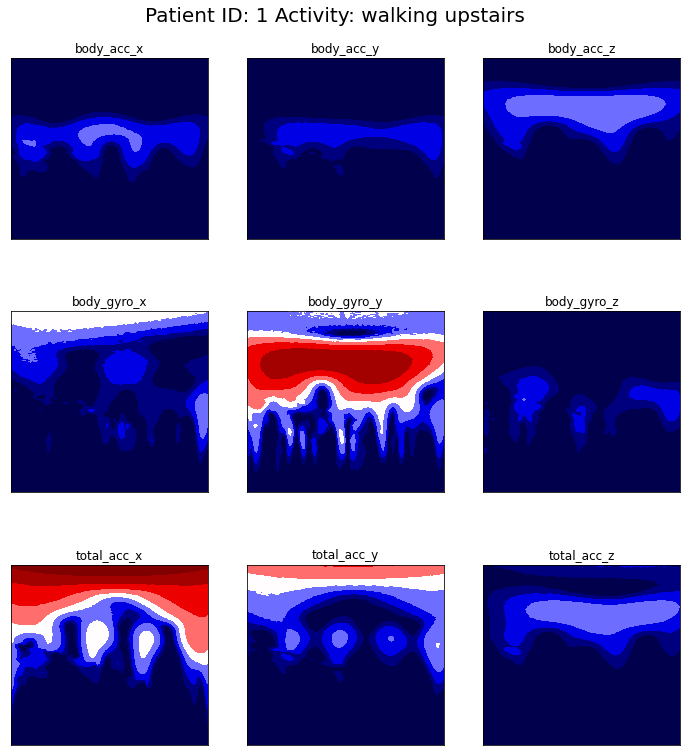

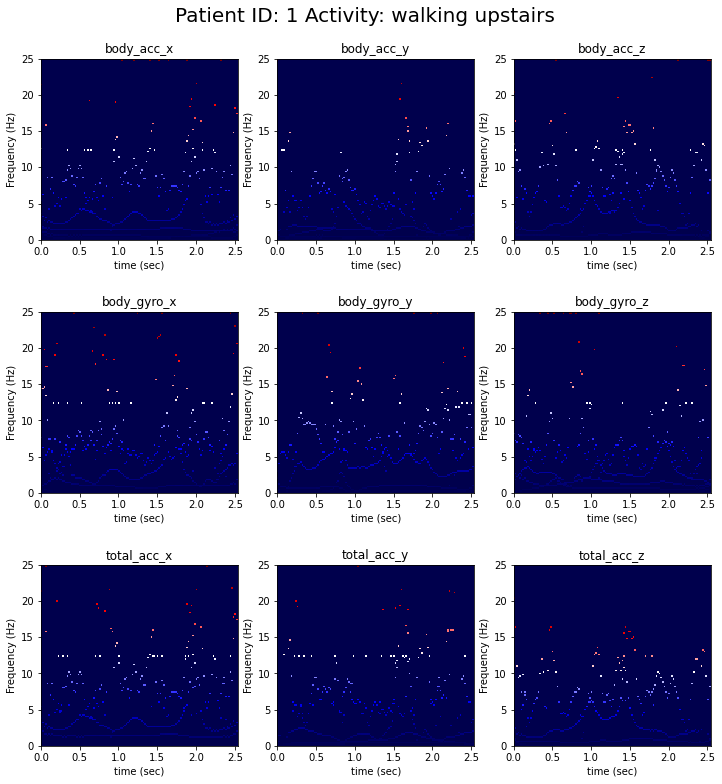

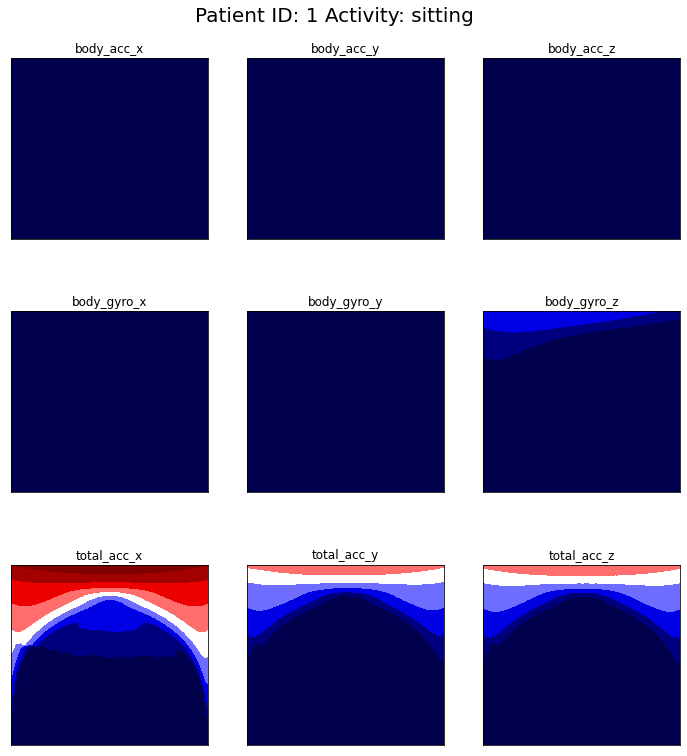

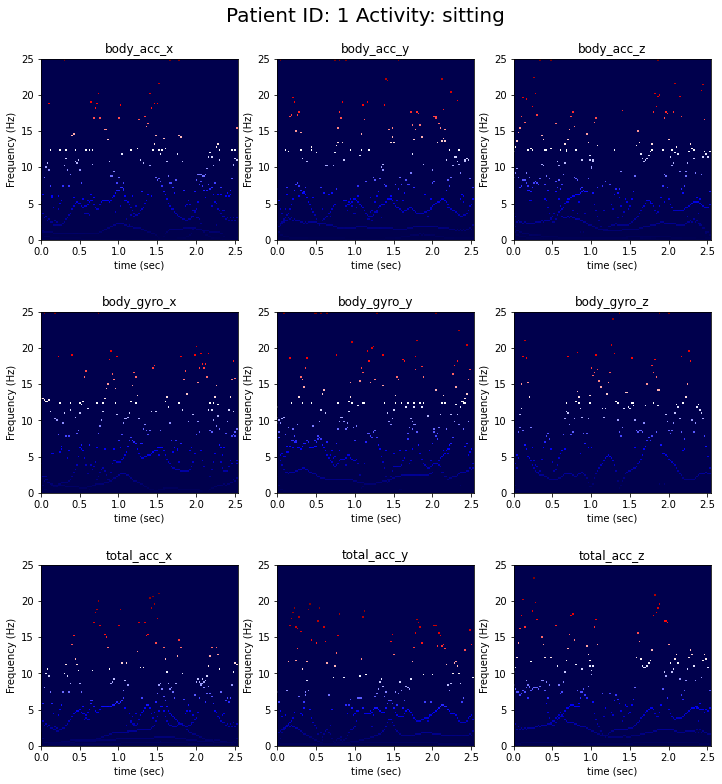

In [27]:
N = 128
t0=0
dt=0.25
time = np.arange(0, N) * dt + t0
fs = 50    
patient_id = 1
spec_activities = {
    2: 'walking upstairs',
    4: 'sitting'
}

for activitiy in spec_activities.keys():
    
    # Aquire data for selected patient slected through patient ID
    patient_labels = y_trainVal[np.where(train_subject_ids == patient_id)[0]]
    patient_signals = X_trainVal[np.where(train_subject_ids == patient_id)[0]]
    
    # Get all indexs where this patient is conducting the desired activitiy
    act_indxs = np.argwhere(patient_labels == activitiy).flatten()
    # Randomly sample from this set of indexs where the patient is conducting the desired activitiy
    indx = np.random.choice(act_indxs, 1)[0]
    
    scales = np.arange(1, 128)
    # plot Wavelet
    fig, axes = plt.subplots(3, 3, figsize=(12,12))
    fig.suptitle("Patient ID: "+str(patient_id)+" Activity: " + activities_description[activitiy], fontsize=20)
    plt.subplots_adjust(top=0.92,hspace=0.4)

    v, h = -1, 0 
    for i, sig in enumerate( patient_signals[indx].T ):
        if i % 3 == 0:
            v+=1
            h = 0
        else:
            h+=1
        plot_wavelet(axes[v][h], time, sig, scales, title=sig_names[i])
    plt.show()
    
    
    # plot HHT
    fig, axes = plt.subplots(3, 3, figsize=(12,12))
    fig.suptitle("Patient ID: "+str(patient_id)+" Activity: " + activities_description[activitiy], fontsize=20)
    plt.subplots_adjust(top=0.92,hspace=0.4)

    v, h = -1, 0 
    for i, sig in enumerate( patient_signals[indx].T ):
        if i % 3 == 0:
            v+=1
            h = 0
        else:
            h+=1
        
        fup = 1000
        n= int((len(sig)/fs)*fup)
        sig = signal.resample(sig, n )
        plot_HHT(axes[v][h], fs, sig, cmap = my_cmap, title = sig_names[i], frequency_resolution = .1, freq_div = 2)
        axes[v][h].set_ylim([0, 25])
    plt.show()
    #break

In [28]:
from sklearn.model_selection import StratifiedKFold

In [44]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Dropout, Flatten, Conv1DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from keras.callbacks import History 
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.utils import to_categorical

from keras.callbacks import EarlyStopping, ModelCheckpoint
from src.keras_custom_utils import CustomStopper, plot_history

In [30]:
# set environment variables 
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
# allow all GPU memory to be consumed by Tensorflow
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [85]:
class cwt_cnn(object):
    def __init__(self, img_x = 127, img_y= 127, n_inputs = 9, 
                 num_classes = 6, model_name = "CWT", learning_rate = 0.001 ):
        
        # define model for neural network 
        cwt_input = Input(shape=(img_x, img_y, n_inputs), name='cwt_image')
        x = Conv2D(filters=32, kernel_size=(5, 5), padding="same", strides = (1, 1), activation="relu", name='e')(cwt_input)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
        
        x = Conv2D(filters=64, kernel_size=(5, 5), padding="same", strides=(2, 2), activation="relu",name='l')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
        x = Flatten()(x)
        x = Dense(100, activation='relu')(x)
        x = Dropout(rate=0.2)(x)
        cwt_out = Dense(num_classes, activation='softmax')(x)
        
        model = Model(cwt_input, cwt_out, name=model_name)
        
        opt = Adam(learning_rate=learning_rate)
        model.compile(loss=categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])
        self.model = model
        
    def summery(self):
        return self.model.summary()
    
    def view_model(self):
        return plot_model(self.model)

In [86]:
cwt = cwt_cnn()
print(cwt.summery())

Model: "CWT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cwt_image (InputLayer)       [(None, 127, 127, 9)]     0         
_________________________________________________________________
e (Conv2D)                   (None, 127, 127, 32)      7232      
_________________________________________________________________
batch_normalization_32 (Batc (None, 127, 127, 32)      128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
l (Conv2D)                   (None, 32, 32, 64)        51264     
_________________________________________________________________
batch_normalization_33 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 16, 16, 64)        0       

In [33]:
from keras.callbacks import History 
history = History()

In [34]:
# test hardware configuration to ensure GPUs are operational 
print( tf.test.is_built_with_cuda() )
print( tf.config.list_physical_devices() )

True
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [128]:
build_wav = False
save = False

scales = range(1,128)
waveletname = 'morl'

if build_wav:
    
    X = np.ndarray(shape=(X_trainVal.shape[0], 127, 127, 9))
    for i in range(X_trainVal.shape[0]):
        for j in range(X_trainVal.T.shape[0]):
            coeff, freq = pywt.cwt(X_trainVal[i, :, j], scales, waveletname, 1)
            X[i, :, :, j] = coeff[:,:127]
    # The values of the label are out of range as it starts at 1 and not 0
    y_trainVal_cat = to_categorical(y_trainVal-1)

    if save:
        np.save('./data/X_morl_wav.npy', X)
        np.save('./data/Y_cat.npy', y_trainVal_cat)
else:
    X = np.load( './data/X_morl_wav.npy' )
    y_trainVal_cat = np.load( './data/Y_cat.npy' )

In [129]:
num_classes = 6
batch_size = 256
epochs = 10

skf = StratifiedKFold( n_splits = 10, shuffle=False )
skf.get_n_splits(X_trainVal, y_trainVal)

for train_index, test_index in skf.split(X_trainVal, y_trainVal):

    X_train, X_Val = X[train_index], X[test_index]
    y_train, y_Val = y_trainVal_cat[train_index], y_trainVal_cat[test_index]
    
    history = History()
    
    # define GPU strategy
    mirrored_strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

    with mirrored_strategy.scope():
        # aquire model with random weights
        model = cwt_cnn()
        model.model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_Val, y_Val), 
              callbacks=[history])
    
    break


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Epoch 1/10
26/26 [==============================] - 9s 132ms/step - loss: 1.8982 - accuracy: 0.6667 - val_loss: 0.5722 - val_accuracy: 0.8139
Epoch 2/10
26/26 [==============================] - 2s 94ms/step - loss: 0.1998 - accuracy: 0.9235 - val_loss: 0.3637 - val_accuracy: 0.8899
Epoch 3/10
26/26 [==============================] - 2s 86ms/step - loss: 0.1320 - accuracy: 0.9445 - val_loss: 0.4453 - val_accuracy: 0.8438
Epoch 4/10
26/26 [==============================] - 2s 85ms/step - loss: 0.1209 - accuracy: 0.9518 - val_loss: 0.6536 - val_accuracy: 0.8166
Epoch 5/10
26/26 [==============================] - 2s 88ms/step - loss: 0.1149 - accuracy: 0.9524 - val_loss: 0.5138 - val_accuracy: 0.8247
Epoch 6/10
26/26 [==============================] - 2s 87ms/step - loss: 0.1147 - accuracy: 0.9490 - val_loss: 0.5315 - val_accuracy: 0.8356
Epoc

In [130]:
train_score = model.model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.model.evaluate(X_Val, y_Val, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train loss: 0.1193210706114769, Train accuracy: 0.9554111361503601
Test loss: 0.16905510425567627, Test accuracy: 0.9442934989929199


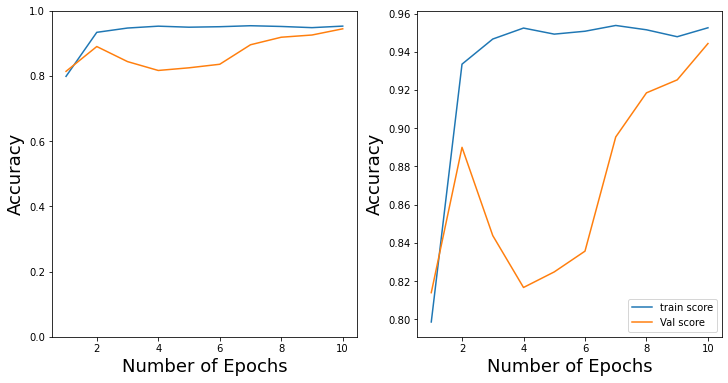

In [131]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(1, 11), history.history['accuracy'], label='train score')
axarr[0].plot(range(1, 11), history.history['val_accuracy'], label='Val score')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1])
axarr[1].plot(range(1, 11), history.history['accuracy'], label='train score')
axarr[1].plot(range(1, 11), history.history['val_accuracy'], label='Val score')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Accuracy', fontsize=18)
#axarr[1].set_ylim([0.9,1])
plt.legend()
plt.show()

In [135]:
y_test_cat = to_categorical(y_test-1) 
X_test_wav = np.ndarray(shape=(X_test.shape[0], 127, 127, 9))
for i in range(X_test.shape[0]):
    for j in range(X_test.T.shape[0]):
        coeff, freq = pywt.cwt(X_test[i, :, j], scales, waveletname, 1)
        X_test_wav[i, :, :, j] = coeff[:,:127]

In [137]:
test_score = model.model.evaluate(X_test_wav, y_test_cat, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Test loss: 0.29144909977912903, Test accuracy: 0.9151679873466492


In [46]:
build_wav = False
save = True

frequency_resolution = 0.01
n_components = 4
freq_div = 2

if build_wav:
    X = np.ndarray(shape=(X_trainVal.shape[0], 126, 128, 9))
    for i in range(X_trainVal.shape[0]):
        for j in range(X_trainVal.T.shape[0]):
            T, F, spec_2d, spec_1d = Hilbert_spectrum(X_trainVal[i, :, j], fs, freq_div = freq_div, 
                                    n_components = n_components, 
                                    frequency_resolution = frequency_resolution)
            X[i, :, :, j] = spec_2d
    # The values of the label are out of range as it starts at 1 and not 0
    y_trainVal_cat = to_categorical(y_trainVal-1)

    if save:
        np.save('./data/X_hht_fr{}_nc{}.npy'.format( frequency_resolution, n_components), X)
        np.save('./data/Y_cat.npy', y_trainVal_cat)
else:
    X = np.load( './data/X_hht_fr{}_nc{}.npy'.format( frequency_resolution, n_components) )
    y_trainVal_cat = np.load( './data/Y_cat.npy' )

In [125]:
build_wav = True
save = False

frequency_resolution = 0.01
n_components = 3
freq_div = 2

if build_wav:
    X = np.ndarray(shape=(X_trainVal.shape[0], 128, 12))
    for i in range(X_trainVal.shape[0]):
        p = []
        for j in range(X_trainVal.T.shape[0]):
            T, F, spec_2d, spec_1d = Hilbert_spectrum(X_trainVal[i, :, j], fs, freq_div = freq_div, 
                                    n_components = n_components, 
                                    frequency_resolution = frequency_resolution)
            
            p.extend([ spec_1d.T[:,[1,2],:].T.reshape(128,-1) ])
            
        break
            # 
            
    # The values of the label are out of range as it starts at 1 and not 0
    y_trainVal_cat = to_categorical(y_trainVal-1)

    if save:
        np.save('./data/X_hht_fr{}_nc{}.npy'.format( frequency_resolution, n_components), X)
        np.save('./data/Y_cat.npy', y_trainVal_cat)
else:
    X = np.load( './data/X_hht_fr{}_nc{}.npy'.format( frequency_resolution, n_components) )
    y_trainVal_cat = np.load( './data/Y_cat.npy' )

In [126]:
for g in p:
    print(g.shape)

(128, 12)
(128, 12)
(128, 10)
(128, 10)
(128, 10)
(128, 12)
(128, 12)
(128, 12)
(128, 12)


In [119]:
np.array()

<ipython-input-119-3a7305c814d7>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(p)


ValueError: could not broadcast input array from shape (128,12) into shape (128)

In [94]:
spec_1d.reshape(-1,128)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64119410e-41, 1.40000000e-01, 1.40000000e-01],
       [1.40000000e-01, 1.40000000e-01, 1.40000000e-01, ...,
        2.80000000e-01, 2.80000000e-01, 2.80000000e-01],
       [2.80000000e-01, 2.80000000e-01, 2.12001439e+01, ...,
        4.20000000e-01, 4.20000000e-01, 4.20000000e-01],
       ...,
       [2.73362899e-07, 2.00839408e-08, 2.41822582e-07, ...,
        2.50000000e+01, 2.87157330e-06, 1.21893311e-07],
       [3.06520718e-07, 4.65079705e-06, 8.59818202e-06, ...,
        4.10532903e-08, 8.53210411e-08, 4.54783364e-06],
       [1.76684015e-05, 1.11755035e-38, 2.42000000e+00, ...,
        9.28586728e-06, 1.40762149e-04, 7.18196312e-40]])

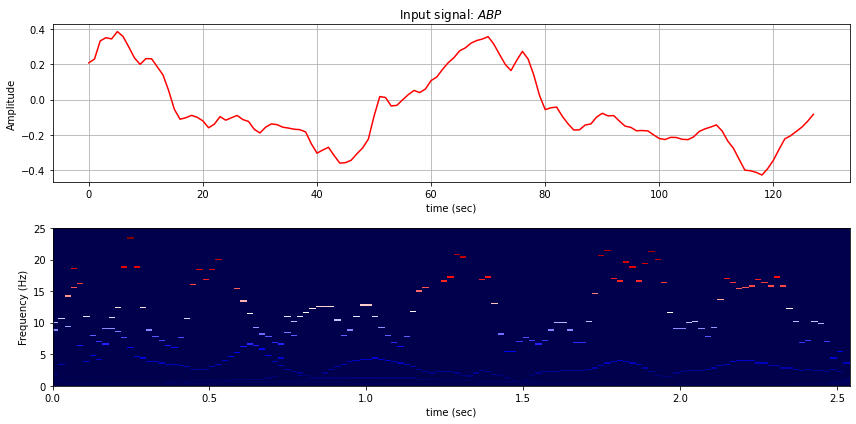

In [75]:
fig, ax = plt.subplots(2, 1,figsize=(12,6))

ax[0].plot( X_trainVal[i, :, j], 'r')
ax[0].title.set_text("Input signal: $ABP$")
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('time (sec)')
ax[0].grid()


ax[1].pcolormesh(T, F, spec_2d, cmap= plt.cm.seismic)
ax[1].set_xlabel('time (sec)')
ax[1].set_ylabel('Frequency (Hz)')
plt.tight_layout()
#plt.savefig('simple_example')
plt.show()

In [72]:
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate, BatchNormalization, Activation, add
from keras.layers import Bidirectional, GRU, Attention, Dense
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

def BP2GRU_Att_DS64(length, n_channel=1,model_name='GRU_Attention'):
    """
    Deeply supervised U-Net with kernels multiples of 64
    
    Arguments:
        length {int} -- length of the input signal
    
    Keyword Arguments:
        n_channel {int} -- number of channels in the output (default: {1})
    
    Returns:
        keras.model -- created model
        
    """
    
    inputs = Input((length, n_channel))
    x = Conv1D(64,3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(64,3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size = 3)(x)
    
    x = Conv1D(128,3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128,3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size = 3)(x)
    
    x = Conv1D(256,3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(256,3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(256,3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size = 3)(x)
    
    x = Conv1D(512,3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(512,3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(512,3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size = 3)(x)
    
    # https://stackoverflow.com/questions/47923370/keras-bidirectional-lstm-seq2seq
    # https://stackoverflow.com/questions/61757475/sequence-to-sequence-for-time-series-prediction
    query, value = GRU(512, return_state=True)(x)
    #seq, forward_h,backward_h = Bidirectional(GRU(512, return_state=True, return_sequences=True),merge_mode="concat")(x)
    # state = concatenate([forward_h, backward_h])
    x = Attention()([query, value])#([seq, tf.expand_dims(state,1)])
    output = Dense(num_classes, activation = 'softmax')(x)
    
    model = Model(inputs = inputs, outputs = output, name = model_name)
    
    return model

In [74]:
BP2GRU_Att_DS64(128, n_channel = 18).summary()

Model: "GRU_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 18)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 64)      3520        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 128, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 128, 64)      12352       batch_normalization_20[0][0]     
______________________________________________________________________________________

In [66]:
num_classes = 6
batch_size = 256
epochs = 200

skf = StratifiedKFold( n_splits = 10, shuffle=False )
skf.get_n_splits(X_trainVal, y_trainVal)

for train_index, test_index in skf.split(X_trainVal, y_trainVal):

    X_train, X_Val = X[train_index], X[test_index]
    y_train, y_Val = y_trainVal_cat[train_index], y_trainVal_cat[test_index]
    
    history = History()
    
    # define GPU strategy
    mirrored_strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

    with mirrored_strategy.scope():
        # aquire model with random weights
        model = cwt_cnn(img_x = 126, img_y= 128,learning_rate = 0.002 )
        model.model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        shuffle = True,
                        verbose=0,
                        validation_data=(X_Val, y_Val), 
                        callbacks=[history])
    
    break

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [50]:
train_score = model.model.evaluate(X_train, y_train, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.model.evaluate(X_Val, y_Val, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Train loss: 0.4341966211795807, Train accuracy: 0.9555622935295105
Test loss: 1.2555716037750244, Test accuracy: 0.570652186870575


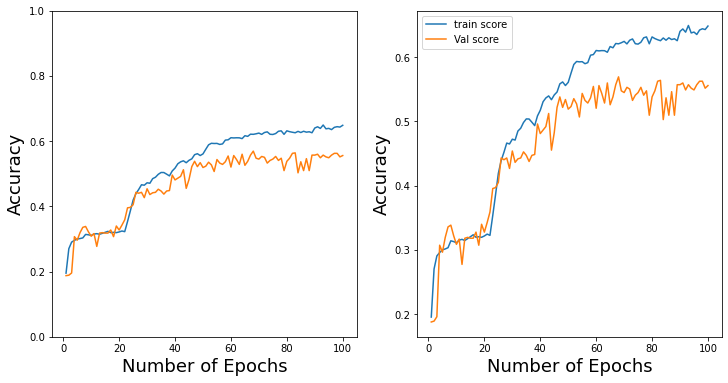

In [58]:
fig, axarr = plt.subplots(figsize=(12,6), ncols=2)
axarr[0].plot(range(1, 101), history.history['accuracy'], label='train score')
axarr[0].plot(range(1, 101), history.history['val_accuracy'], label='Val score')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0,1])
axarr[1].plot(range(1, 101), history.history['accuracy'], label='train score')
axarr[1].plot(range(1, 101), history.history['val_accuracy'], label='Val score')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Accuracy', fontsize=18)
#axarr[1].set_ylim([0.9,1])
plt.legend()
plt.show()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
https://uk.mathworks.com/help/signal/ug/hilbert-transform.html
https://towardsdatascience.com/instantaneous-phase-and-magnitude-with-the-hilbert-transform-40a73985be07
https://www.sciencedirect.com/topics/engineering/hilbert-transform
https://www.comm.utoronto.ca/frank/notes/hilbert.pdf


https://www.gaussianwaves.com/2017/04/analytic-signal-hilbert-transform-and-fft/
https://www.comm.utoronto.ca/frank/notes/hilbert.pdf

https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/

file:///C:/Users/ebolger2/Downloads/energies-10-00188-v2.pdf

https://www.researchgate.net/post/What_is_the_difference_between_wavelet_transform_and_Hilbert-Huang_transform#:~:text=Wavelet%20transform%20convolves%20a%20signal,basis%20function%20or%20mother%20wavelet.

https://www.kaggle.com/code/asauve/a-gentle-introduction-to-wavelet-for-data-analysis/notebook

https://dsp.stackexchange.com/questions/69614/inverse-hilbert-transform

https://pyhht.readthedocs.io/en/latest/tutorials/hilbert_view_nonlinearity.html

https://www.tandfonline.com/doi/abs/10.1080/00423110802167466

https://fairyonice.github.io/implement-the-spectrogram-from-scratch-in-python.html

https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/
https://archive.ics.uci.edu/ml/index.php
https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/

https://github.com/taspinar/siml/tree/master/notebooks
https://github.com/taspinar/siml/blob/master/notebooks/WV2%20-%20Visualizing%20the%20Scaleogram%2C%20time-axis%20and%20Fourier%20Transform.ipynb
https://github.com/taspinar/siml/blob/master/notebooks/WV3%20-%20Classification%20of%20signals%20using%20the%20CWT%20and%20CNN.ipynb
https://notebook.community/Mashimo/datascience/00-tidyData/CleanDataHAR

In [77]:
np.random.shuffle(train_index)
#train_index

In [78]:
y_trainVal[train_index][0:10]

array([4, 4, 5, 1, 1, 2, 6, 4, 6, 1])

# References

**Fast Fourier Transform**
* Cooley, James W., and John W. Tukey, 1965, “An algorithm for the machine calculation of complex Fourier series,” Math. Comput. 19: 297-301.

* Bluestein, L., 1970, “A linear filtering approach to the computation of discrete Fourier transform”. IEEE Transactions on Audio and Electroacoustics. 18 (4): 451-455.

* D. Gabor, “Theory of communications”, Journal of the Inst. Electr. Eng., vol. 93, pt. 111, pp. 42-57, 1946. See definition of complex signal on p. 432.

* J. A. Ville, “Theorie et application de la notion du signal analytique”, Cables el Transmission, vol. 2, [pp. 61-74, 1948](https://ieeexplore.ieee.org/document/1163127).


The Fourier transform generalizes Fourier coefficients of a signal over time. Since the Fourier coefficients are the measures of the signal amplitude as a function of frequency, the time information is totally lost. 

A powerful variant of the Fourier transform is the wavelet transform. By using finite-support basis functions, wavelets are able to approximate even nonstationary data. These basis functions possess most of the desirable properties required for linear decomposition (like orthogonality, completeness , etc) and they can be drawn from a large dictionary of wavelets. This makes the wavelet transform a versatile tool for analysis of nonstationary data. But the wavelet transform is still a linear decomposition and hence suffers from related problems like the uncertainty principle. Moreover, like Fourier, the wavelet transform too is non-adaptive. The basis functions are selected a priori and consequently make the wavelet decomposition prone to spurious harmonics and ultimately incorrect interpretations of the data.

A remarkable advantage of Fourier based methods is their mathematical framework. Fourier based methods are so elegant that they make building models for a given dataset very easy. Although such models can represent most of the data and are extensive enough for a practical application, the fact remains that there is some amount of data slipping through the gaps left behind by linear approximations. Despite all these shortcomings, wavelet analysis still remains the best possible method for analysis of nonstationary data, and hence should be used as a reference to establish the validity of other methods.

The Hilbert-Huang transform is an algorithm developed empirically to overcome these short commings, however there is no well-defined mathematical base. All inferences drawn from it are empirical and can only be corroborated as such. It lacks the mathematical sophistication of the Fourier framework. On the plus side it provides a very realistic insight into data.

Thus here we have room for a tradeoff between the mathematical elegance of the Fourier analysis and the physical significance provided by the Hilbert-Huang transform. Wavelets are the closest thing to the HHT that not only have the ability to analyze nonlinear and nonstationary phenomena, but also a complete mathematical foundation. Unfortunately wavelets are not adaptive and as such might suffer from problems like uncertainty principle, leakages, Gibb’s phenomenon, harmonics, etc - like most of the decomposition techniques that use a priori basis functions.